## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from collections import Counter
from scipy.spatial import distance
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import cluster, metrics, datasets
import seaborn as sns 
# importing more models that I may need.


# For 3D plots
import plotly
plotly.tools.set_credentials_file(username='lawrencefsoto', api_key='Sg9BCjSVRVWL5jklUegz')


import plotly.plotly as py
import plotly.graph_objs as go

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 700) # want to see more rows and columns

## Reading In My Data

In [2]:
df = pd.read_csv('../Scraping/clean_season_17_18') # reading data
df.shape #check shape

(372, 44)

In [3]:
# checking to see if all the numerical columns are not strings
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 44 columns):
Name    372 non-null object
2P      372 non-null float64
2P%     372 non-null float64
2PA     372 non-null float64
3P      372 non-null float64
3P%     372 non-null float64
3PA     372 non-null float64
AST     372 non-null float64
Age     372 non-null int64
BLK     372 non-null float64
DRB     372 non-null float64
DRtg    372 non-null int64
FG      372 non-null float64
FG%     372 non-null float64
FGA     372 non-null float64
FT      372 non-null float64
FT%     372 non-null float64
FTA     372 non-null float64
G       372 non-null int64
GS      372 non-null int64
MP      372 non-null float64
ORB     372 non-null float64
ORtg    372 non-null int64
PF      372 non-null float64
PTS     372 non-null float64
Pos     372 non-null object
STL     372 non-null float64
TOV     372 non-null float64
TRB     372 non-null float64
Tm      372 non-null object
AST%    372 non-null float64
BLK%    3

In [4]:
df.set_index('Name', inplace=True) # changin name to index
df = df[df['G']>=40] # only have players that play more than 40 games
sg=df[df['Pos']=='SG']
sg = sg.reindex(sorted(sg.columns), axis=1) # sort columns
sg.head() # sanity check

2P    2P%   2PA   3P    3P%  3PA  AST  AST%  Age  BLK  BLK%  \
Name                                                                          
Alex Abrines   1.4  0.443   3.1  3.7  0.380  9.7  1.2   3.4   24  0.4   0.6   
Arron Afflalo  2.7  0.413   6.6  1.9  0.386  5.0  2.2   6.2   32  0.6   1.1   
Dwayne Bacon   4.2  0.409  10.2  0.8  0.256  2.9  2.6   7.5   22  0.1   0.2   
Will Barton    5.7  0.510  11.2  2.9  0.370  7.8  6.1  18.5   27  1.0   1.6   
Nicolas Batum  4.4  0.473   9.3  2.3  0.336  6.7  8.6  26.2   29  0.6   1.0   

               BPM  DBPM  DRB  DRB%  DRtg   FG    FG%   FGA   FT    FT%  FTA  \
Name                                                                           
Alex Abrines  -2.2  -1.7  3.9   8.9   110  5.0  0.395  12.7  1.7  0.848  2.0   
Arron Afflalo -5.8  -1.8  4.5  10.1   115  4.7  0.401  11.6  1.6  0.846  1.9   
Dwayne Bacon  -5.7  -0.3  8.2  18.5   111  4.9  0.375  13.1  1.4  0.800  1.7   
Will Barton    1.0  -0.6  6.3  14.2   112  8.6  0.452  19.0  3.4  0.805  4.2   
Nicolas Batum  1.4   0.5  6.1  13.8   110  6.6  0.415  16.0  2.7  0.831  3.2   

                G  GS      MP  OBPM  ORB  ORB%  ORtg   PER   PF   PTS Pos  \
Name                                                                        
Alex Abrines   75   8  1134.0  -0.5  1.1   2.5   116   9.0  5.4  15.4  SG   
Arron Afflalo  53   3   682.0  -4.1  0.3   0.6    98   5.8  4.0  12.8  SG   
Dwayne Bacon   53   6   713.0  -5.4  0.3   0.6    88   5.8  3.1  12.0  SG   
Will Barton    81  40  2683.0   1.6  1.3   3.0   113  16.2  3.1  23.4  SG   
Nicolas Batum  64  64  1981.0   0.9  1.4   3.1   107  14.4  1.8  18.2  SG   

               STL  STL%  TOV  TOV%  TRB  TRB%    TS%   Tm  USG%  VORP  
Name                                                                    
Alex Abrines   1.7   1.7  1.1   7.4  5.0   5.6  0.567  OKC  12.7  -0.1  
Arron Afflalo  0.3   0.3  1.5  10.8  4.7   5.3  0.516  ORL  12.5  -0.7  
Dwayne Bacon   1.1   1.1  1.6  10.2  8.5   9.4  0.431  CHO  13.7  -0.7  
Will Barton    1.5   1.5  2.8  11.7  7.6   8.6  0.562  DEN  20.7   2.0  
Nicolas Batum  1.6   1.6  3.2  15.6  7.5   8.4  0.523  CHO  18.3   1.7

## Clustering SG w/ Kmeans

In [5]:
X = sg.drop(columns=['G','GS','MP','Age','Pos','Tm']) ## took out columns that don't matter to the model
ss=StandardScaler()
sg_scaled=ss.fit_transform(X)

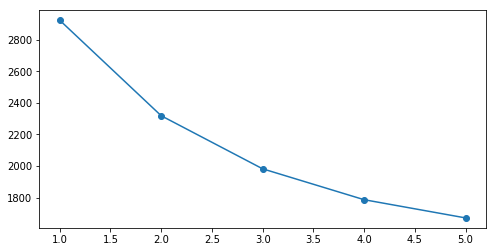

In [6]:
## looking best cluster with inertia for Kmeans first before Modeling out my SG's

cluster_range = range( 1, 6 )
cluster_errors = []

for num_clusters in cluster_range:
    sgclusters = KMeans(num_clusters)
    sgclusters.fit(sg_scaled)
    cluster_errors.append(sgclusters.inertia_)

clusters_df = pd.DataFrame({ "num_clusters":cluster_range, "cluster_errors": cluster_errors })

plt.figure(figsize=(8,4))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" );

In [7]:
# From this graph I am looking for an elbow and it seems that 3 clusters may be best for this model.

In [8]:
# Want to check how the cluster performs w/ labels, centriod, intertia and silhouette_score

def performance(data, n_clusters): 
    
    performance = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    performance = performance.fit(data)
    labels = performance.labels_
    centroids = performance.cluster_centers_
    inertia = performance.inertia_
    sil_score = metrics.silhouette_score(data, performance.labels_, metric='euclidean')

    data_dictionary = {
        "labels": labels,
        "centroids": centroids,
        "inertia" : inertia,
        "silhouette_score": sil_score
    }

    return data_dictionary

In [9]:
performance(sg_scaled,3)

{'labels': array([1, 1, 2, 2, 2, 2, 0, 1, 1, 1, 0, 1, 2, 2, 2, 0, 2, 1, 0, 1, 1, 1,
        1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 2, 0, 1,
        1, 1, 1, 1, 2, 1, 2, 2, 0, 2, 1, 0, 1, 1, 2, 0, 2, 2, 1, 1, 2, 2,
        2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1], dtype=int32),
 'centroids': array([[ 1.70402905,  0.46719539,  1.64707283,  0.09394561, -0.12686931,
          0.13348191,  1.3680085 ,  1.53881959,  0.19116928,  0.1818186 ,
          1.43842563,  0.21668061,  0.01721538,  0.01557076, -0.48132025,
          1.65647813,  0.7722916 ,  1.51948302,  1.7032428 ,  0.38012997,
          1.67402369,  1.49829911,  0.24976882,  0.27655059,  0.63232979,
          1.7694226 , -0.58220726,  1.68263765,  0.70200958,  0.70200958,
          1.36592547,  0.21016083,  0.08560327,  0.1083953 ,  0.54918854,
          1.65077708,  1.66207571],
        [-0.45863097, -0.1054266 , -0.45066522,  0.44584764,  0.32021145,
          0.40993952, -0.44963973, -0.44309588, -0.36071708, -0.3

In [10]:
# this will plot my silhouette score so I can better visualize my clusters from ranges a-b

def find_best_cluster(data,a,b):
    scores = []
    for i in range(a,b):
        i_clusters = performance(data, i)
        sil_score_i = i_clusters['silhouette_score']
        scores.append(sil_score_i)

    sns.set_context('poster', font_scale=1)
    plt.plot(range(a,b), scores)
    plt.title("""Measuring Silhouette Score to Find Best Cluster""")
    print ("best silhouette score:", np.max(scores))

best silhouette score: 0.1900187207038489


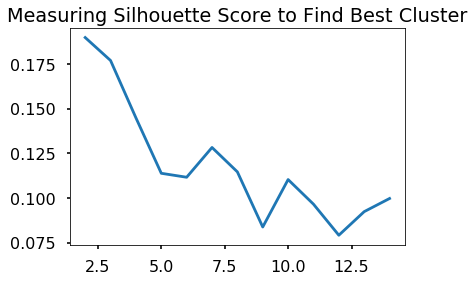

In [11]:
find_best_cluster(sg_scaled,2,15)

In [12]:
# from silhouette score it seems that 2 or 3 is the best will go with 2 clusters.

## Picking Cluster and Modeling

In [13]:
sgk= KMeans(n_clusters=2, random_state=42)
sgk.fit(sg_scaled)
sg['sg_cluster'] = sgk.labels_
Counter(sgk.labels_)

Counter({0: 52, 1: 27})

In [14]:
sg[sg['sg_cluster']==0] ## checking cluster 0

2P    2P%   2PA   3P    3P%   3PA  AST  AST%  Age  \
Name                                                                           
Alex Abrines              1.4  0.443   3.1  3.7  0.380   9.7  1.2   3.4   24   
Arron Afflalo             2.7  0.413   6.6  1.9  0.386   5.0  2.2   6.2   32   
Dwayne Bacon              4.2  0.409  10.2  0.8  0.256   2.9  2.6   7.5   22   
Malik Beasley             3.8  0.469   8.2  2.4  0.341   7.0  2.6   7.4   21   
Marco Belinelli           4.7  0.509   9.2  3.7  0.377   9.9  3.7  11.9   31   
Bogdan Bogdanovic         5.0  0.485  10.3  3.0  0.392   7.7  6.0  18.3   25   
Avery Bradley             6.4  0.436  14.6  2.6  0.369   7.0  3.3  10.4   27   
Sterling Brown            3.2  0.439   7.3  2.1  0.352   5.8  1.6   4.5   22   
Kentavious Caldwell-Pope  3.5  0.473   7.5  3.1  0.383   8.1  3.2   9.4   24   
Ian Clark                 5.2  0.533   9.8  2.0  0.318   6.4  3.6  10.4   26   
Pat Connaughton           3.0  0.506   6.0  2.5  0.352   7.0  3.0   8.7   25   
Allen Crabbe              3.0  0.461   6.5  4.4  0.378  11.8  2.6   8.4   25   
Jamal Crawford            6.2  0.477  12.9  3.1  0.331   9.5  5.6  16.9   37   
Troy Daniels              1.4  0.419   3.5  5.4  0.400  13.5  1.4   4.5   26   
Tyler Dorsey              3.6  0.393   9.2  3.6  0.362  10.0  4.0  12.5   21   
Damyean Dotson            5.2  0.538   9.7  2.3  0.324   7.1  3.2   9.5   23   
Wayne Ellington           1.4  0.479   3.0  5.6  0.392  14.2  1.9   5.9   30   
Terrance Ferguson         2.0  0.612   3.2  2.6  0.333   7.8  1.2   3.4   19   
Yogi Ferrell              3.9  0.477   8.2  2.9  0.373   7.9  4.4  13.5   24   
Bryn Forbes               4.0  0.446   9.0  3.0  0.390   7.6  2.7   7.8   24   
Langston Galloway         2.9  0.418   7.1  4.3  0.344  12.6  3.4  10.1   26   
Eric Gordon               4.5  0.544   8.3  5.0  0.359  13.9  3.5  11.7   29   
Treveon Graham            2.6  0.452   5.8  1.9  0.412   4.5  2.7   7.8   24   
Danny Green               2.8  0.419   6.8  3.3  0.363   9.0  3.1   8.9   30   
Gerald Green              3.1  0.504   6.1  5.8  0.369  15.8  1.3   4.3   32   
Joe Harris                3.8  0.589   6.5  3.7  0.419   8.8  3.1  10.2   26   
Josh Hart                 3.2  0.551   5.8  2.6  0.396   6.5  2.6   7.6   22   
Justin Holiday            2.8  0.387   7.2  3.5  0.359   9.7  3.3  10.1   28   
Rodney Hood               6.0  0.467  12.9  3.9  0.381  10.3  2.9   9.7   25   
Luke Kennard              4.3  0.463   9.2  2.8  0.415   6.6  4.2  12.7   21   
Sean Kilpatrick           4.9  0.427  11.5  3.5  0.319  11.0  3.5  11.3   28   
Kyle Korver               1.8  0.537   3.4  5.1  0.436  11.7  2.7   8.0   36   
Courtney Lee              4.9  0.482  10.2  2.4  0.406   6.0  3.9  11.3   32   
DeAndre Liggins           1.4  0.396   3.6  1.3  0.358   3.6  3.3   8.4   29   
Patrick McCaw             3.7  0.503   7.3  1.0  0.238   4.0  4.1  10.6   22   
Ben McLemore              4.7  0.477   9.9  2.5  0.346   7.4  2.4   7.5   24   
Jodie Meeks               3.8  0.464   8.1  3.2  0.343   9.3  3.1   9.1   30   
Malik Monk                4.0  0.385  10.4  4.7  0.342  13.9  5.2  16.9   19   
E'Twaun Moore             5.4  0.556   9.8  2.4  0.425   5.6  3.5  10.1   28   
Brandon Paul              3.5  0.548   6.4  1.3  0.278   4.7  3.2   9.0   26   
Norman Powell             4.5  0.516   8.7  2.5  0.285   8.6  4.1  11.8   24   
J.J. Redick               4.8  0.504   9.5  4.4  0.420  10.5  4.8  15.1   33   
Austin Rivers             4.8  0.461  10.5  3.2  0.378   8.5  5.7  17.5   25   
Marcus Smart              3.5  0.429   8.2  2.3  0.301   7.7  8.0  23.7   23   
J.R. Smith                2.1  0.453   4.7  3.1  0.375   8.3  3.1   8.6   32   
Tony Snell                1.9  0.490   3.8  2.6  0.403   6.5  2.4   6.5   26   
Nik Stauskas              1.9  0.370   5.0  3.7  0.400   9.3  3.6  11.1   24   
Garrett Temple            3.4  0.442   7.8  2.8  0.392   7.1  3.9  11.3   31   
Jason Terry               1

In [15]:
# double checking my model predicting for one of my players.

marco = pd.DataFrame(sg.loc['Marco Belinelli'][:43]).T.drop(columns=['Age','G','GS','MP','Pos','Tm'])
marco_scaled=ss.transform(marco)
sgk.predict(marco_scaled)

array([0], dtype=int32)

In [16]:
# checks the distance from each cluster and why it got clustered to cluster 0

for i in range(0,2):
    print('dist between evan_scaled and cluster', i, ':', distance.euclidean(marco_scaled, sgk.cluster_centers_[i]))

dist between evan_scaled and cluster 0 : 4.284781670161704
dist between evan_scaled and cluster 1 : 5.928734863173626


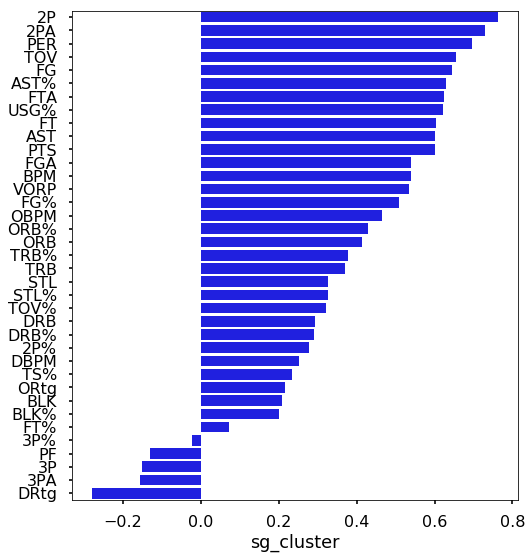

In [17]:
## want to see correlation of each feature to see how each feature effected the cluster

sg_corr = sg.drop(columns=['Age','G','GS','MP','Pos','Tm'])
corr=sg_corr.corr()
corr = corr.sort_values('sg_cluster',ascending=False)


plt.figure(figsize=(8,9))
sns.barplot(corr.sg_cluster[1:], corr.index[1:], color='b')
plt.show();

In [18]:
## from this bar graph it seems 2P,2PA PER(player efficiency rating) are high indicators where sg will cluster
## DRtg is negative indicator where sg will cluster Defensive Rating

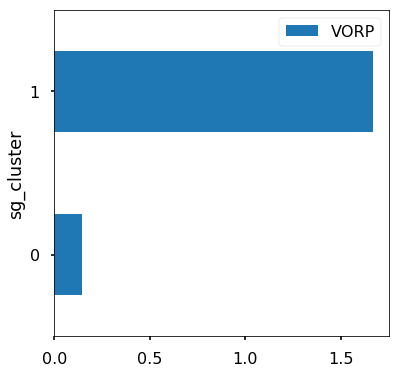

In [19]:
test= sg[['VORP','sg_cluster']] ## VORP is Value Over Replacement Player shows which cluster is most valuable
test.groupby(['sg_cluster']).mean().plot(kind='barh', figsize=(6,6));

In [20]:
## seems like sg_cluster 1 are more important players.

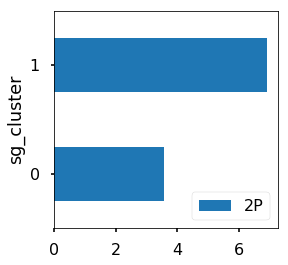

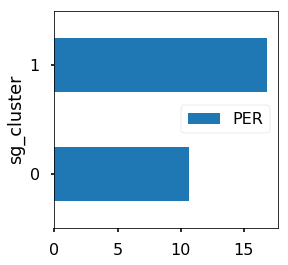

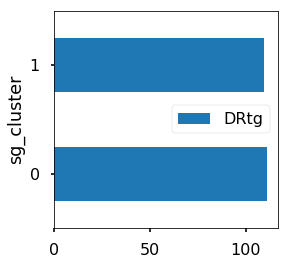

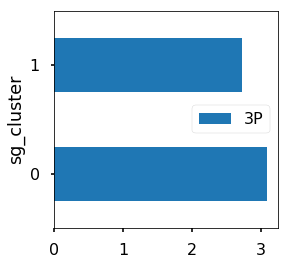

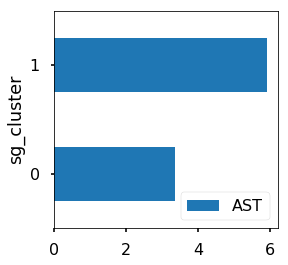

In [21]:
test1= sg[['2P','sg_cluster']]
test1.groupby(['sg_cluster']).mean().plot(kind='barh', figsize=(4,4));

test2= sg[['PER','sg_cluster']]
test2.groupby(['sg_cluster']).mean().plot(kind='barh', figsize=(4,4));

test3= sg[['DRtg','sg_cluster']]
test3.groupby(['sg_cluster']).mean().plot(kind='barh', figsize=(4,4)); # DRtg seems the same

test4= sg[['3P','sg_cluster']]
test4.groupby(['sg_cluster']).mean().plot(kind='barh', figsize=(4,4));# DRtg seems the same

test5= sg[['AST','sg_cluster']]
test5.groupby(['sg_cluster']).mean().plot(kind='barh', figsize=(4,4)); # DRtg seems the same

In [22]:
## seems like sg_cluster are mostly bench players. not much different other sg0 probably plays a lot less than sg1
## resulting more 2P for sg1 and more 3P for sg0

In [23]:
## sg1 starters tend to shoot more 2's and higher usage rate and a lot higher assist rate
## sg0 lower usage rate a slight higher 3 shooting comin off the bench
## sg1 High assist sg more usable
## sg0 specialist shooting 3's don't need high usage rate. - Marco Belinelli,Avery Bradley,Kentavious Caldwell-Pope
# Allen Crabbe
## sg1 - Nicolas Batum,Jimmy Butler,James Harden,Bradley Beal

## Conclusion
SG1 shoots more 2P and attempt more 2PA, higher PER(Player Effiecency Rating), more TOV, more AST and AST%
<br/>Passing 2's - Nicolas Batum, Victor Oladipo, Jimmy Butler, James Harden

SG0 shoots slightly more 3PA and makes more 3P, bench players, specialize in 3's
<br/>Shooting 2's - Marco Bellinelli, Avery Bradley, Kentavious Caldwell-Pope, Josh Hart

Value
<br/> SG1>SG0

In [24]:
trace1 = go.Scatter3d(
    x=sg['2P'],
    y=sg['3P'],
    z=sg['AST'],
    mode='markers',
    marker=dict(
        size=12,
        color=sg['sg_cluster'],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)
data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

In [25]:
# Can Visually see where the clusters are different

In [26]:
## Run these cells to pickle.
##from sklearn.externals import joblib

##joblib.dump(ss, './sg_scaler.pk1')

##joblib.dump(sgk, './sg_kmeans.pk1')

In [27]:
sg.to_csv('./sg_cluster_17_18')